In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import numpy as np
import math
import torch
import gpytorch
from sklearn.preprocessing import *

In [51]:
# def weighted_err(mean_pred,l,u,true_val):
#     s=0
#     for i in range(len(mean_pred)):
#         s+=abs((mean_pred[i]-true_val[i]))/(u[i]-l[i])
#     error=s/len(mean_pred)
#     return error

In [52]:
df=pd.read_excel("UGP_Data.xlsx",sheet_name="Data_Model")

In [53]:
df.head()

,wt%,salt [mM],tan delta,delta,Temp,n,noise_n,FD,noise_fd,tg,log_tg,noise_tg,time [h],G',"G""",avg_noise_tg,noise_log_tg,S,log_S,noise_S
0,2.8,0.0,0.469,0.438542,30,0.279184,NaN,2.243474,NaN,4332.000000,3.636688,NaN,71.9575,7.760626,3.706306,28.928000,1.461318,8.214593,0.914586,NaN
1,3.0,0.0,0.383,0.365766,30,0.232854,NaN,2.289626,NaN,2967.883333,3.472447,NaN,49.464722,16.086607,6.871555,28.928000,1.461318,16.823833,1.225925,NaN
2,3.2,0.0,0.372,0.356138,30,0.226724,NaN,2.295617,NaN,1672.450000,3.223353,NaN,27.874167,20.881245,8.530632,28.928000,1.461318,21.804691,1.338550,NaN
3,3.4,0.0,0.343,0.330425,30,0.210355,NaN,2.311486,NaN,796.066667,2.900949,NaN,13.267778,26.493461,9.972796,28.928000,1.461318,27.553845,1.440182,NaN
4,3.6,0.0,0.336,0.324149,30,0.206359,0.000857,2.315331,0.000824,649.033333,2.812267,48.841667,10.817222,31.042231,10.967994,48.841667,1.688790,32.253468,1.508576,9.100433


In [54]:
dfx=df[["wt%","salt [mM]","Temp"]]
dfy=df[["n","log_tg","log_S"]]

In [55]:
idx=dfx["Temp"]!=30

In [56]:
X=np.array(dfx)
y=np.array(dfy)

In [58]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=45)
outputs=["wt(%)","Salt","Temp"]

In [59]:
sc_X=StandardScaler()
sc_X.fit(X)
X_train_sc=sc_X.transform(X_train)
X_test_sc=sc_X.transform(X_test)

In [11]:
print("X Scaler mean",sc_X.mean_)

X Scaler mean [ 2.5826087   3.24347826 30.        ]


In [12]:
print("X Scaler var",sc_X.var_)

X Scaler var [ 0.55100189  5.22941399 21.73913043]


In [13]:
X_train_sc

array([[-1.32374416,  1.6427043 ,  0.        ],
       [-1.86261347,  0.76811636,  0.        ],
       [ 0.29286375, -0.10647158, -2.14476106],
       [ 0.29286375, -0.10647158,  4.28952212],
       [-0.24600555, -0.10647158,  0.        ],
       [-1.59317882,  0.76811636,  0.        ],
       [-1.32374416,  0.76811636,  0.        ],
       [-1.05430951,  1.6427043 ,  0.        ],
       [ 0.0234291 , -0.10647158,  0.        ],
       [ 0.29286375,  0.76811636,  0.        ],
       [ 1.10116771, -0.98105951,  0.        ],
       [-0.78487486, -0.10647158,  0.        ],
       [-0.51544021,  1.6427043 ,  0.        ],
       [-0.78487486,  1.6427043 ,  0.        ],
       [ 1.90947167, -1.41835348,  0.        ],
       [ 0.56229841, -0.10647158,  0.        ],
       [ 0.29286375, -0.10647158,  2.14476106],
       [-1.32374416, -0.10647158,  0.        ],
       [-1.05430951,  0.76811636,  0.        ],
       [ 0.83173306, -1.41835348,  0.        ],
       [-0.24600555, -0.98105951,  0.   

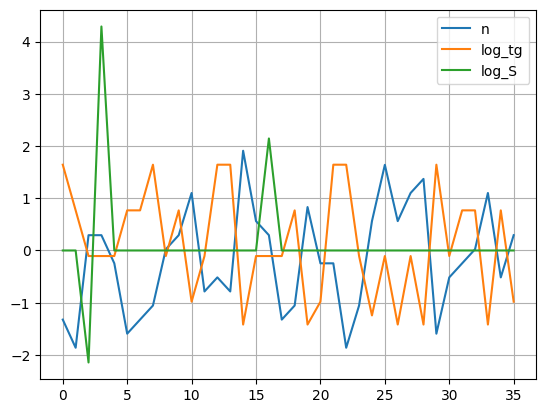

In [14]:
plt.plot(X_train_sc)
plt.legend(["n","log_tg","log_S"])
plt.grid()

In [15]:
sc_y=StandardScaler()
sc_y.fit(y)
y_train_sc=sc_y.transform(y_train)
y_test_sc=sc_y.transform(y_test)

In [16]:
print("Y Scaler mean",sc_y.mean_)

Y Scaler mean [0.36045261 2.52201917 0.32363501]


In [17]:
print("Y Scaler var",sc_y.var_)

Y Scaler var [0.01803499 0.37730585 0.74858488]


In [18]:
n_mean=sc_y.mean_[0]
n_var=sc_y.var_[0]
tg_mean=sc_y.mean_[1]
tg_var=sc_y.var_[1]
s_mean=sc_y.mean_[2]
s_var=sc_y.var_[2]

In [19]:
y_train_sc

array([[ 1.72650439, -0.60716762, -1.57345004],
       [ 2.30011024,  1.05739518, -2.0112543 ],
       [-0.29305743, -0.17427013,  0.23861522],
       [-0.73898131, -1.03158339,  0.497535  ],
       [ 0.13711709,  0.71827462, -0.15793078],
       [ 1.57842561,  0.78079709, -1.50249553],
       [ 1.12292656,  0.35331652, -1.18887056],
       [ 1.31973748, -1.03356707, -1.33605547],
       [-0.34055094,  0.24944861,  0.21704451],
       [-0.39227764, -1.36194208,  0.14505496],
       [-1.00828842, -0.07036503,  1.03875156],
       [ 0.31877105,  1.11985096, -0.40150072],
       [ 0.60280879, -1.71457196, -0.80890596],
       [ 0.89254941, -1.48138167, -1.04323674],
       [-1.35914128, -0.11684134,  1.64068914],
       [-0.57416086, -0.15707707,  0.39347779],
       [-0.52803573, -0.72903668,  0.42495998],
       [ 1.24095728,  1.57057237, -1.13679202],
       [ 0.85451482,  0.25148673, -0.94745162],
       [-0.99578354,  1.14176863,  1.17302997],
       [ 0.64179681,  1.18283471, -0.367

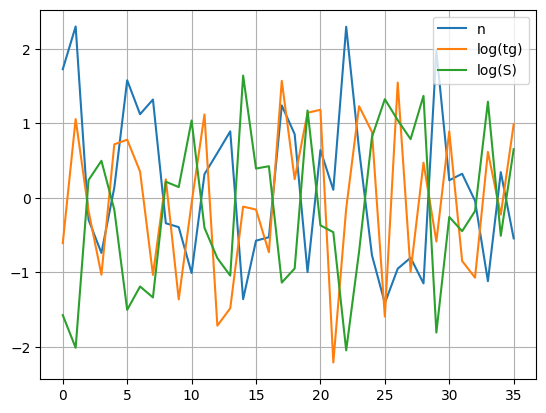

In [20]:
plt.plot(y_train_sc)
plt.legend(["n","log(tg)","log(S)"])
plt.grid()

In [22]:
X_test_sc

tensor([[ 0.2929, -0.1065,  0.0000],
        [ 1.1012, -1.2434,  0.0000],
        [-0.7849,  0.7681,  0.0000],
        [ 0.0234, -1.2434,  0.0000],
        [ 1.6400, -1.4184,  0.0000],
        [ 1.9095, -0.1065,  0.0000],
        [ 0.2929, -0.1065, -4.2895],
        [ 0.2929, -0.1065,  0.0000],
        [ 0.2929, -1.4184,  0.0000],
        [ 0.8317, -0.1065,  0.0000]], dtype=torch.float64)

### Creating Polynomial Feature Matrix

In [48]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4)
X_train_poly_sc=poly.fit_transform(X_train_sc)
X_test_poly_sc=poly.transform(X_test_sc)

In [49]:
X_train_poly_sc.shape

(36, 35)

### Sparse Regression Model for n

In [25]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# Initialize the Lasso model with a chosen alpha value
lasso_n = Lasso(alpha=0.04)
# Fit the model on the training data
lasso_n.fit(X_train_poly_sc, y_train_sc[:,0])
# Predict on the training data
n_pred_train_sc = lasso_n.predict(X_train_poly_sc)
# Calculate and print the mean squared error
mse_train = mean_squared_error(y_train_sc[:,0], n_pred_train_sc)
# Predict on the test data
n_pred_test_sc = lasso_n.predict(X_test_poly_sc)
# Calculate and print the mean squared error
mse_test = mean_squared_error(y_test_sc[:,0], n_pred_test_sc)

print("Mean Squared Train Error in scaled space:",mse_train)
print("Mean Squared Test Error in scaled space:",mse_test)


Mean Squared Train Error in scaled space: 0.030452764867215112
Mean Squared Test Error in scaled space: 0.025008960519810976


In [26]:
lasso_n.coef_

array([ 0.        , -0.69613005,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.05755402,  0.        , -0.        , -0.01214059,  0.        ,
       -0.        ,  0.06636512, -0.        ,  0.        , -0.00246166,
        0.039197  , -0.00911893, -0.        ,  0.0014448 ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.00072615])

In [27]:
n_pred=n_pred_test_sc*np.sqrt(n_var)+n_mean

In [28]:
n_pred

array([0.31938952, 0.22389838, 0.43136563, 0.32755278, 0.17550496,
       0.18546365, 0.31246635, 0.31938952, 0.29308847, 0.26730305])

In [29]:
y_test[:,0]

tensor([0.3002, 0.2628, 0.4205, 0.3389, 0.1914, 0.1542, 0.3349, 0.2982, 0.2792,
        0.2649], dtype=torch.float64)

In [30]:
mse_n=mean_squared_error(y_test[:,0],n_pred)
print("Mean Squared Test Error for n:",mse_n)

Mean Squared Test Error for n: 0.0004510362747153306


### Sparse Regresssion for tg

In [31]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# Initialize the Lasso model with a chosen alpha value
lasso_tg = Lasso(alpha=0.04)
# Fit the model on the training data
lasso_tg.fit(X_train_poly_sc, y_train_sc[:,1])
# Predict on the training data
tg_pred_train_sc = lasso_tg.predict(X_train_poly_sc)
# Calculate and print the mean squared error
mse_train_tg = mean_squared_error(y_train_sc[:,1], tg_pred_train_sc)
# Predict on the test data
tg_pred_test_sc = lasso_tg.predict(X_test_poly_sc)
# Calculate and print the mean squared error
mse_test_tg = mean_squared_error(y_test_sc[:,1], tg_pred_test_sc)
print("Mean Squared Train Error in scaled space:",mse_train_tg)
print("Mean Squared Test Error in scaled space:",mse_test_tg)

Mean Squared Train Error in scaled space: 0.04265589984964148
Mean Squared Test Error in scaled space: 0.03929359341879051


In [32]:
lasso_tg.coef_

array([ 0.00000000e+00, -8.13663731e-01, -8.77992674e-01, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -2.91604537e-02, -5.47871591e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.56819741e-01, -0.00000000e+00,  0.00000000e+00, -8.65439925e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -7.25022857e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  8.05444015e-04])

In [33]:
tg_pred=tg_pred_test_sc*np.sqrt(tg_var)+tg_mean

In [34]:
tg_pred

array([2.45064157, 2.81024103, 2.49254517, 3.38459641, 2.63281009,
       1.40922717, 2.70814001, 2.45064157, 3.43660823, 2.1628025 ])

In [35]:
y_test[:,1]

tensor([2.2038, 2.7259, 2.4078, 3.4045, 2.7508, 1.4833, 2.6362, 2.5249, 3.6367,
        2.1128], dtype=torch.float64)

In [36]:
mse_tg=mean_squared_error(y_test[:,1],tg_pred)
print("Mean Squared Test Error for tg:",mse_tg)

Mean Squared Test Error for tg: 0.01482570284721243


In [60]:
X_sc=sc_X.transform(X)
X_poly=poly.transform(X_sc)

### Sparse Regression for S

In [37]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# Initialize the Lasso model with a chosen alpha value
lasso_s = Lasso(alpha=0.03)
# Fit the model on the training data
lasso_s.fit(X_train_poly_sc, y_train_sc[:,2])
# Predict on the training data
s_pred_train_sc = lasso_s.predict(X_train_poly_sc)
# Calculate and print the mean squared error
mse_train_s = mean_squared_error(y_train_sc[:,2], s_pred_train_sc)
# Predict on the test data
s_pred_test_sc = lasso_s.predict(X_test_poly_sc)
# Calculate and print the mean squared error
mse_test_s = mean_squared_error(y_test_sc[:,2], s_pred_test_sc)
print("Mean Squared Train Error in scaled space:",mse_train_s)
print("Mean Squared Test Error in scaled space:",mse_test_s)

Mean Squared Train Error in scaled space: 0.0165900745969967
Mean Squared Test Error in scaled space: 0.011133879219310963


In [38]:
lasso_s.coef_

array([ 0.00000000e+00,  7.07971112e-01, -4.20922598e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  3.20740520e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -1.06283347e-01,  0.00000000e+00, -0.00000000e+00,  1.43765696e-03,
       -2.28663835e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  1.33487732e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  4.32436481e-04])

In [39]:
s_pred=s_pred_test_sc*np.sqrt(s_var)+s_mean
s_pred

array([ 0.53497551,  1.28320181, -0.21627947,  0.61507694,  1.69569978,
        1.45485856,  0.56347152,  0.53497551,  0.89176618,  0.87100341])

In [40]:
y_test[:,2]

tensor([ 0.6217,  1.1335, -0.2553,  0.5807,  1.6101,  1.6101,  0.5082,  0.6513,
         0.9146,  0.9175], dtype=torch.float64)

In [41]:
mse_s=mean_squared_error(y_test[:,2],s_pred)
print("Mean Squared Test Error for S:",mse_s)

Mean Squared Test Error for S: 0.008334653668849468


In [66]:
n_comp_sc=lasso_n.predict(X_poly)
n_comp=n_comp_sc*np.sqrt(n_var)+n_mean
tg_comp_sc=lasso_tg.predict(X_poly)
tg_comp=tg_comp_sc*np.sqrt(tg_var)+tg_mean
s_comp_sc=lasso_s.predict(X_poly)
s_comp=s_comp_sc*np.sqrt(s_var)+s_mean

In [68]:
print("MSE for n on complete dataset",mean_squared_error(n_comp,y[:,0]))

MSE for n on complete dataset 0.0005278719668515474


In [69]:
print("MSE for log(tg) on complete dataset",mean_squared_error(tg_comp,y[:,1]))

MSE for log(tg) on complete dataset 0.01581853424838092


In [70]:
print("MSE for log(S) on complete dataset",mean_squared_error(s_comp,y[:,2]))

MSE for log(S) on complete dataset 0.01153116048526525


### Testing the S vs n hypthesis with Sparse Regression Model

In [42]:
weight_var_3=np.arange(1.2,5,0.05)
sz=len(weight_var_3)
X_test_3=np.transpose(np.vstack((weight_var_3,3*np.ones(sz),30*np.ones(sz))))
X_test_3_sc=sc_X.transform(X_test_3)

In [43]:
X_test_3

array([[ 1.2 ,  3.  , 30.  ],
       [ 1.25,  3.  , 30.  ],
       [ 1.3 ,  3.  , 30.  ],
       [ 1.35,  3.  , 30.  ],
       [ 1.4 ,  3.  , 30.  ],
       [ 1.45,  3.  , 30.  ],
       [ 1.5 ,  3.  , 30.  ],
       [ 1.55,  3.  , 30.  ],
       [ 1.6 ,  3.  , 30.  ],
       [ 1.65,  3.  , 30.  ],
       [ 1.7 ,  3.  , 30.  ],
       [ 1.75,  3.  , 30.  ],
       [ 1.8 ,  3.  , 30.  ],
       [ 1.85,  3.  , 30.  ],
       [ 1.9 ,  3.  , 30.  ],
       [ 1.95,  3.  , 30.  ],
       [ 2.  ,  3.  , 30.  ],
       [ 2.05,  3.  , 30.  ],
       [ 2.1 ,  3.  , 30.  ],
       [ 2.15,  3.  , 30.  ],
       [ 2.2 ,  3.  , 30.  ],
       [ 2.25,  3.  , 30.  ],
       [ 2.3 ,  3.  , 30.  ],
       [ 2.35,  3.  , 30.  ],
       [ 2.4 ,  3.  , 30.  ],
       [ 2.45,  3.  , 30.  ],
       [ 2.5 ,  3.  , 30.  ],
       [ 2.55,  3.  , 30.  ],
       [ 2.6 ,  3.  , 30.  ],
       [ 2.65,  3.  , 30.  ],
       [ 2.7 ,  3.  , 30.  ],
       [ 2.75,  3.  , 30.  ],
       [ 2.8 ,  3.  , 30.  ],
       [ 2

In [66]:
X_test_3_poly=poly.transform(X_test_3_sc)